<a href="https://colab.research.google.com/github/BiakkoNoMiko/homework_projects/blob/main/HW_ML_evaluation_metrics%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание по Python #31  Классификация: "Оценка точности модели, переобучение, регуляризация" Лузановой Е.В.
Курс: dsn-cp-2

<div> ## Задача
 Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.</div>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [ ]:
# Открываем таблицу, пропуски обозначены через знаки вопроса, указываем при считывании
df= pd.read_csv('/content/athletes.csv')
df.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


### 1. Общая инфо и пропуски

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


При этом:  5 признаков строковых:
name
nationality
sex
dob
sport

## Работа с пропусками

In [ ]:
# Количество пропусков. Создадим фрейм с двумя столбцами: абсолютными и относительными величинами
null_values=pd.DataFrame(df.isna().sum(),columns=['NaN'])
null_values['percent'] = (df.isna().mean() * 100)
null_values.sort_values('percent',ascending=False).round(2)

,NaN,percent
weight,659,5.71
height,330,2.86
dob,1,0.01
id,0,0.00
name,0,0.00
nationality,0,0.00
sex,0,0.00
sport,0,0.00
gold,0,0.00
silver,0,0.00


У нас отсутствуют данные по весу и росту. Рост можно взять медиану от вида спорта и пола. А вес- взаимосвязь с полом и ростом.

In [ ]:
df_fill = df.copy()
#Проверим медиану при группировке по полу и спорту
print(df.groupby(['sport', 'sex'])['height'].median())
df_fill['height'] = df['height'].fillna(df.groupby(['sport', 'sex'])['height'].transform('median'))

sport              sex   
aquatics           female    1.720
                   male      1.870
archery            female    1.680
                   male      1.800
athletics          female    1.690
                   male      1.810
badminton          female    1.680
                   male      1.800
basketball         female    1.850
                   male      2.010
boxing             female    1.680
                   male      1.750
canoe              female    1.700
                   male      1.830
cycling            female    1.670
                   male      1.800
equestrian         female    1.680
                   male      1.790
fencing            female    1.715
                   male      1.830
football           female    1.680
                   male      1.800
golf               female    1.680
                   male      1.800
gymnastics         female    1.630
                   male      1.670
handball           female    1.760
                   male      

In [ ]:
#Для работы с пропусками сделаем биннинг роста с равным количеством наблюдей внутри одного бина.
df_fill['height_bin'] = pd.qcut(df_fill['height'], 5)

In [ ]:
#Проверим медиану при группировке по росту и полу
print(df_fill.groupby(['height_bin', 'sex'])['weight'].median())
df_fill['weight'] = df_fill['weight'].fillna(df_fill.groupby(['height_bin', 'sex'])['weight'].transform('median'))

height_bin     sex   
(1.209, 1.67]  female    55.0
               male      60.0
(1.67, 1.73]   female    62.0
               male      67.0
(1.73, 1.8]    female    67.0
               male      73.0
(1.8, 1.86]    female    74.0
               male      79.0
(1.86, 2.21]   female    78.0
               male      90.0
Name: weight, dtype: float64


In [ ]:
df_fill[df_fill['dob'].isna()].head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,height_bin
8546,663676373,Pavel Sozykin,RUS,male,NaN,1.81,79.0,sailing,0,0,0,"(1.8, 1.86]"


Возможно данные нам и не пригодятся, но для одного случая на такую тему можно и погуглить. Находим Павла Созыкина, яхтсмена, с датой рождения 25 декабря 1987

In [ ]:
df_fill.loc[(df_fill['name'] == 'Pavel Sozykin'),'dob'] = '12/25/87'

In [ ]:
# Количество пропусков. Создадим фрейм с двумя столбцами: абсолютными и относительными величинами
null_values=pd.DataFrame(df_fill.isna().sum(),columns=['NaN'])
null_values['percent'] = (df_fill.isna().mean() * 100)
null_values.sort_values('percent',ascending=False).round(2)

,NaN,percent
id,0,0.0
name,0,0.0
nationality,0,0.0
sex,0,0.0
dob,0,0.0
height,0,0.0
weight,0,0.0
sport,0,0.0
gold,0,0.0
silver,0,0.0


Имя, в принципе, тоже важно для определения пола. Выцепим из колонки с ФИ имя. Сложность в том, что это мультинациональная таблица, бывает и по 3, 4 имени. И тут надо подстраиваться под страну, но для наших целей возмем 1 - имя, последнее - фамилия

In [ ]:
df_fill['firstName'] = df_fill['name'].astype(str).str.split().str[0] #Переводим в строчку и разбиваем строчку, берем 0 значение
df_fill['lastName'] = df_fill['name'].astype(str).str.split().str[-1]

In [ ]:
df_fill[(df_fill['name'].astype(str).str.split().str.len()>2)] # Сколько у нас всего имен больших. 1570 строчек

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,height_bin,firstName,lastName
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0,"(1.67, 1.73]",A,Garcia
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0,"(1.67, 1.73]",A,Shin
8,87689776,Aauri Lorena Bokesa,ESP,female,12/14/88,1.80,62.0,athletics,0,0,0,"(1.73, 1.8]",Aauri,Bokesa
11,591319906,Abbas Abubakar Abbas,BRN,male,5/17/96,1.75,66.0,athletics,0,0,0,"(1.73, 1.8]",Abbas,Abbas
19,334169879,Abd Elhalim Mohamed Abou,EGY,male,6/3/89,2.10,88.0,volleyball,0,0,0,"(1.86, 2.21]",Abd,Abou
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11514,424586991,Zohra Ez Zahraoui,MAR,female,11/18/83,1.65,55.0,boxing,0,0,0,"(1.209, 1.67]",Zohra,Zahraoui
11517,495365659,Zoltan Adam Harcsa,HUN,male,11/20/92,1.84,79.0,boxing,0,0,0,"(1.8, 1.86]",Zoltan,Harcsa
11521,281890328,Zoulehia Abzetta Dabonne,CIV,female,12/15/92,1.75,57.0,judo,0,0,0,"(1.73, 1.8]",Zoulehia,Dabonne
11536,900065925,le Quoc Toan Tran,VIE,male,4/5/89,1.60,56.0,weightlifting,0,0,0,"(1.209, 1.67]",le,Tran


#### Подготавливаем данные

In [ ]:
a = df_fill.iloc[:,[2,7,12]] # Категориальные признаки (попробуем оставить и национальность и дату рождения). Дату рождения убрала, потому что ресурсов компа не хватает
b = df_fill.iloc[:,[5,6,8,9,10]] #Вещественные
a.head(5)

,nationality,sport,firstName
0,ESP,athletics,A
1,KOR,fencing,A
2,CAN,athletics,Aaron
3,MDA,taekwondo,Aaron
4,NZL,cycling,Aaron


In [ ]:
a_ohe = pd.get_dummies(a)
a_ohe.head()

,nationality_AFG,nationality_ALB,nationality_ALG,nationality_AND,nationality_ANG,nationality_ANT,nationality_ARG,nationality_ARM,nationality_ARU,nationality_ASA,...,firstName_Zoya,firstName_Zsanett,firstName_Zsofia,firstName_Zsombor,firstName_Zsuzsanna,firstName_Zurabi,firstName_Zurian,firstName_Zuzana,firstName_di,firstName_le
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
a_ohe.shape

(11538, 6029)

In [ ]:
b.shape

(11538, 5)

In [ ]:
#Склеиваем обратно
c = pd.concat([b, a_ohe], axis = 1)

In [ ]:
c.head(10)

,height,weight,gold,silver,bronze,nationality_AFG,nationality_ALB,nationality_ALG,nationality_AND,nationality_ANG,...,firstName_Zoya,firstName_Zsanett,firstName_Zsofia,firstName_Zsombor,firstName_Zsuzsanna,firstName_Zurabi,firstName_Zurian,firstName_Zuzana,firstName_di,firstName_le
0,1.72,64.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.68,56.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.98,79.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.83,80.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.81,71.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.80,67.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2.05,98.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.93,100.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1.80,62.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1.65,54.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Поменяем пол c помощью LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit( df_fill['sex'] )
le.classes_
# df_fill['sex'] = df_fill['sex'].map({'male':0, 'female':1}).values

array(['female', 'male'], dtype=object)

In [ ]:
y = pd.Series( data = le.transform( df_fill['sex'] ) )
y.head()

0    1
1    0
2    1
3    1
4    1
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42) #Делим выборку 80/20 и закрепляем рандом

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline # используем пайплайны для удобства
from sklearn.preprocessing import StandardScaler # масштабируем данные для лучшего обучения


model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [ ]:
model.fit(X_train, y_train) #Обучаем модель

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [ ]:
predictions = model.predict_proba(X_test)
predictions

array([[3.28154681e-08, 9.99999967e-01],
       [9.99715516e-01, 2.84484403e-04],
       [9.73606182e-01, 2.63938182e-02],
       ...,
       [8.73607355e-03, 9.91263926e-01],
       [7.89210293e-01, 2.10789707e-01],
       [7.25117659e-06, 9.99992749e-01]])

In [ ]:
model.score(X_train, y_train)

0.9993499458288191

In [ ]:
model.score(X_test, y_test)

0.8765164644714039

#### Считаем accuracy последней модели вручную

In [ ]:
#Обернем в функцию и добавим порог для будущих целей
def pos_neg( predictions, y_test, threshold=0.5):
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative

    for predicted_prob, actual in zip( predictions[:, 1], y_test ):
        if predicted_prob >= threshold:
            predicted = 1
        else:
            predicted = 0

        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1

        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1

    fpr_single = fp / (fp + tn)
    tpr_single = tp / (tp + fn)

    return tp, fp, fn, tn, fpr_single, tpr_single
#fp = np.sum((y_pred == 1) & (y_true == 0))
#tp = np.sum((y_pred == 1) & (y_true == 1))
#fn = np.sum((y_pred == 0) & (y_true == 1))
#tn = np.sum((y_pred == 0) & (y_true == 0))

In [ ]:
predictions = model.predict_proba( X_test )

tp, fp, fn, tn, fpr_single, tpr_single = pos_neg( predictions, y_test, threshold=0.5)


In [ ]:
tp, fp, fn, tn, fpr_single, tpr_single

(1136, 150, 135, 887, 0.1446480231436837, 0.8937844217151849)

In [ ]:
precision_single = tp / (tp + fp)
recall_single = tp / (tp + fn)

In [ ]:
precision_single, recall_single

(0.8833592534992224, 0.8937844217151849)

In [ ]:
#Автоматом через библиотеку
from sklearn.metrics import recall_score, precision_score
pred = model.predict(X_test)
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)
print(precision, recall)

0.8833592534992224 0.8937844217151849


### ROC

In [ ]:
# посчитаем ROC-кривую (Receiver Operating Characteristic)
from sklearn.metrics import roc_curve

In [ ]:
fpr, tpr, thres = roc_curve( y_test, predictions[:, 1] )

In [ ]:
for line in zip( fpr[:10], tpr[:10], thres[:10] ):
    print( line )

(0.0, 0.0, 1.9999999999141906)
(0.0, 0.0007867820613690008, 0.9999999999141906)
(0.0, 0.1022816679779701, 0.999998613159236)
(0.0009643201542912247, 0.1022816679779701, 0.9999986097359234)
(0.0009643201542912247, 0.46420141620771044, 0.9992896277696455)
(0.0019286403085824494, 0.46420141620771044, 0.9992894598721187)
(0.0019286403085824494, 0.4783634933123525, 0.9991251696212423)
(0.0028929604628736743, 0.4783634933123525, 0.9990886125282662)
(0.0028929604628736743, 0.5200629425649095, 0.9982867437549717)
(0.003857280617164899, 0.5200629425649095, 0.9982775763065963)


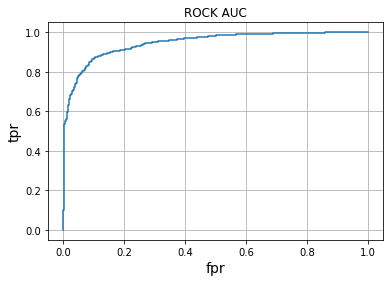

In [ ]:
plt.plot( fpr, tpr )
plt.grid()
plt.xlabel("fpr", fontsize = 14)
plt.ylabel("tpr", fontsize = 14)
plt.title('ROCK AUC');

In [ ]:
# значение AUC метрики
sklearn.metrics.roc_auc_score( y_test, predictions[:, 1] )

0.947086061211189

In [ ]:
# Модель, которая ничего не умеет и ее предсказания (базовая линия)
no_skill_probs = [0 for _ in range(len(y_test))]

In [ ]:
sklearn.metrics.roc_auc_score(y_test, no_skill_probs)

0.5

In [ ]:
no_skill_fpr, no_skill_tpr, no_skill_thres = roc_curve(y_test, no_skill_probs)

In [ ]:
from sklearn.metrics import auc

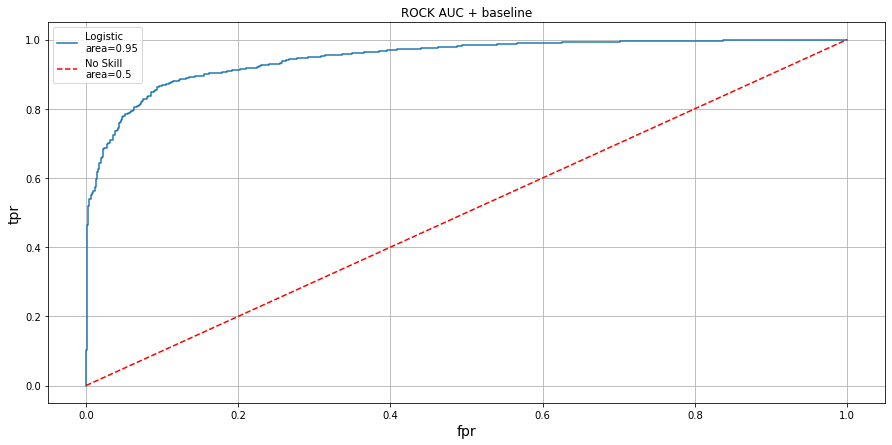

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot( fpr, tpr, label='Logistic' + '\n' + 'area=' + str(round(auc( fpr, tpr ),2)))
plt.plot( no_skill_fpr, no_skill_tpr, c='r', linestyle='--', label='No Skill'+ '\n' + 'area=' + str(round(auc( no_skill_fpr, no_skill_tpr ),2)) )
plt.grid()
plt.xlabel("fpr", fontsize = 14)
plt.ylabel("tpr", fontsize = 14)
plt.legend(loc='best')
plt.title('ROCK AUC + baseline');

##### Подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.

In [ ]:
#thresholds = np.linspace(0, 1, 500) # Создаем массив от 0 до 1 с определеныым числом элементов и равными интервалами между ними. Это будут значения порога для проверки.
                                    #Чем больше число элементов, тем более сглаженная будет кривая
thresholds = np.sort(np.unique(predictions[:,1])) #берем все предсказанные вероятности и сортируем от меньшей к большей

def roc_curve_manual(predictions, y_true, thresholds):
    fpr = []
    tpr = []

    for i in thresholds:
        tp, fp, fn, tn, fpr_single, tpr_single  = pos_neg( predictions, y_test, threshold=i) #высчитываем показатели для каждого значения порога
        fpr.append(fpr_single)
        tpr.append(tpr_single)
    return fpr, tpr

In [ ]:
fpr_manual, tpr_manual = roc_curve_manual(predictions = predictions, y_true=y_test, thresholds=thresholds)
for line in zip( fpr_manual[:10], tpr_manual[:10], thres[:10] ):
    print( line )

(1.0, 1.0, 5.206910710434844e-05)
(0.9990356798457087, 1.0, 5.2490837089107145e-05)
(0.9980713596914176, 1.0, 5.30477333294165e-05)
(0.9971070395371263, 1.0, 5.323245506666819e-05)
(0.996142719382835, 1.0, 5.3999189324393805e-05)
(0.9951783992285439, 1.0, 5.4997218381647986e-05)
(0.9942140790742526, 1.0, 5.5370956962746866e-05)
(0.9932497589199615, 1.0, 5.583611778140681e-05)
(0.9922854387656702, 1.0, 5.59517333322123e-05)
(0.991321118611379, 1.0, 5.692930804223339e-05)


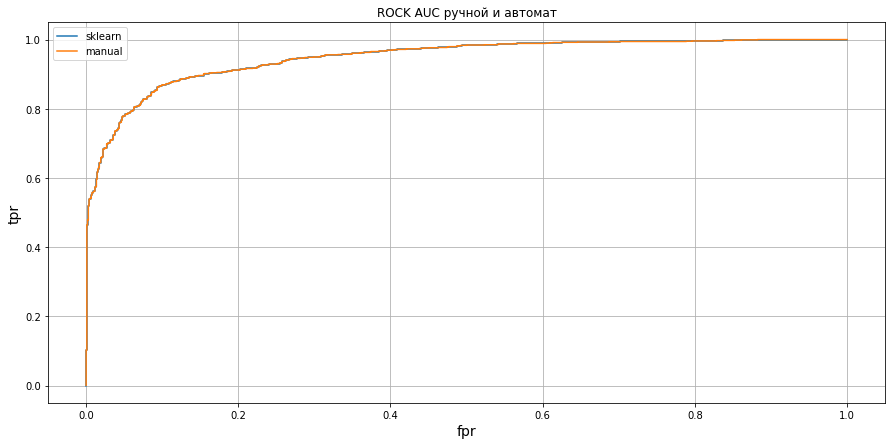

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot( fpr, tpr, label = 'sklearn' )
plt.plot( fpr_manual, tpr_manual, label = 'manual')
plt.grid()
plt.xlabel("fpr", fontsize = 14)
plt.ylabel("tpr", fontsize = 14)
plt.legend(loc='best')
plt.title('ROCK AUC ручной и автомат')
plt.show();

При количестве элементов в нашем массиве с порогами, тем более гладкая у нас линия и приближенная к той, что считает sklearn. При num = 500 уже отлично

 Показатели радуют. Попробую для интереса построить еще одну модель и сравнить их между собой. Оставим только рост и массу, как предлагали в комментариях.


#### Сравнение моделей с разным количеством признаков

In [ ]:
Xshort = df_fill.loc[ :, ['height', 'weight'] ]
Xshort.head()

,height,weight
0,1.72,64.0
1,1.68,56.0
2,1.98,79.0
3,1.83,80.0
4,1.81,71.0


In [ ]:
model2 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))


In [ ]:
X_train_short, X_test_short, y_train, y_test = train_test_split( Xshort, y, test_size = 0.3, random_state = 42 )

In [ ]:
model2.fit( X_train_short, y_train )

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [ ]:
predictions2 = model2.predict_proba( X_test_short )

In [ ]:
fpr2, tpr2, thres2 = roc_curve( y_test, predictions2[:, 1] )

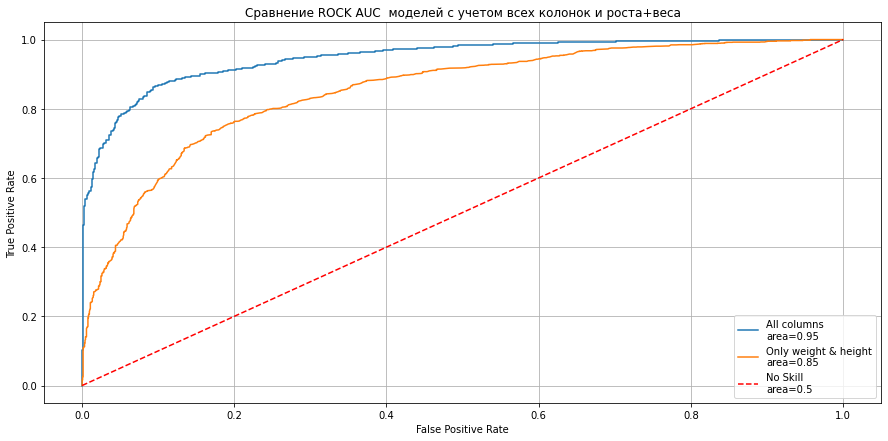

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot( fpr, tpr, label = 'All columns' + '\n' + 'area=' + str(round(auc( fpr, tpr ),2)) )
plt.plot( fpr2, tpr2, label = 'Only weight & height'  + '\n' + 'area=' + str(round(auc( fpr2, tpr2 ),2)))
plt.plot( no_skill_fpr, no_skill_tpr, c='r', linestyle='--', label='No Skill'+ '\n' + 'area=' + str(round(auc( no_skill_fpr, no_skill_tpr ),2)) )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROCK AUC  моделей с учетом всех колонок и роста+веса')
plt.legend( loc = 'best' )
plt.grid()
plt.show()

In [ ]:
auc( fpr, tpr )

0.947086061211189

In [ ]:
auc( fpr2, tpr2 )

0.8522708458962376

Сомневаюсь в нужности количества медалей и национальности. Проверим. (по итогу, проверила и спорт, тоже убрала)

In [ ]:
a2 = df_fill.iloc[:,12] # Оставляем имя (первое)
a_ohe2 = pd.get_dummies(a2)
b2 = df_fill.iloc[:,[5,6]] #Вещественные рост и вес
c2 = pd.concat([b2, a_ohe2], axis = 1)
c2.head()

,height,weight,A,Aaron,Aauri,Ababel,Abadi,Abbas,Abbey,Abbie,...,Zoya,Zsanett,Zsofia,Zsombor,Zsuzsanna,Zurabi,Zurian,Zuzana,di,le
0,1.72,64.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.68,56.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.98,79.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.83,80.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.81,71.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train_short2, X_test_short2, y_train, y_test = train_test_split(c2, y, test_size=0.2, random_state=42) #Делим выборку 80/20 и закрепляем рандом

In [ ]:
model3 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))


In [ ]:
model3.fit( X_train_short2, y_train )

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [ ]:
predictions3 = model3.predict_proba( X_test_short2 )

In [ ]:
fpr3, tpr3, thres3 = roc_curve( y_test, predictions3[:, 1] )

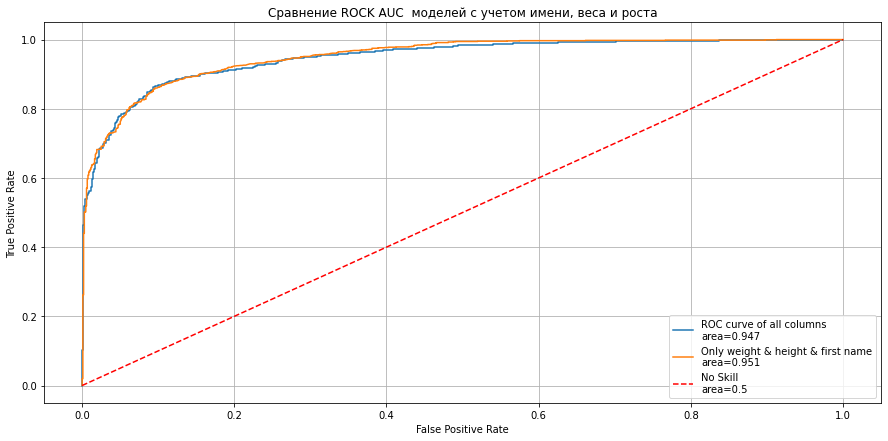

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot( fpr, tpr, label = 'ROC curve of all columns' + '\n' + 'area=' + str(round(auc( fpr, tpr ),3)))
plt.plot( fpr3, tpr3, label = 'Only weight & height & first name' + '\n' + 'area=' + str(round(auc( fpr3, tpr3 ),3)))
plt.plot( no_skill_fpr, no_skill_tpr, c='r', linestyle='--', label='No Skill'+ '\n' + 'area=' + str(round(auc( no_skill_fpr, no_skill_tpr ),2)) )
plt.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROCK AUC  моделей с учетом имени, веса и роста')
plt.legend( loc = 'best' )
plt.grid()
plt.show()

In [ ]:
np.trapz(tpr3,fpr3) #вручную берем интеграл и получаем площадь под кривыми, то есть значение ROCK AUC

0.9509270295676795

Как видим без спорта, медалей и национальности результат тот же(и даже чуть лучше). Медали и национальность лучше исключить. Со спортом auc на 0.002 единицы лучше, но для экономии ресурсов лучше исключить.

Для усовершенствования модели можно было бы еще сделать отбор имен по национальности, чтобы лучше определить, где есть имя, где фамилия. Или использовать сторонние библиотеки с женскими и мужскими и сверять. Но показатели модели и с грубой разбивкой радуют.

#### Построим график Precision-Recall, используя метрики, посчитанные в п. 5. для нашей третьей модели. То есть вручную же?

In [ ]:
thresholds = np.sort(np.unique(predictions[:,1])) #берем все предсказанные вероятности и сортируем от меньшей к большей


def prec_rec_manual(predictions, y_true, thresholds):
    precision = []
    recall = []

    for i in thresholds:
      tp, fp, fn, tn, fpr_single, tpr_single  = pos_neg( predictions, y_test, threshold=i) #высчитываем показатели для каждого значения порога
      if (tp + fp) == 0:
        continue
      else:
        precision_single = tp / (tp + fp)
        recall_single = tp / (tp + fn)
        recall.append(recall_single)
        precision.append(precision_single)

    return precision, recall

In [ ]:
precision_manual3, recall_manual3 = prec_rec_manual(predictions = predictions3, y_true=y_test, thresholds=thresholds)


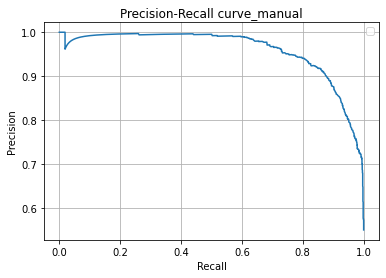

In [ ]:
plt.plot( recall_manual3, precision_manual3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve_manual')
plt.legend( loc = 'best' )
plt.grid()
plt.show()

In [ ]:
# метод для построения графика precision-recall
from sklearn.metrics import precision_recall_curve
pr, re, thres = precision_recall_curve( y_test, predictions3[:, 1] )

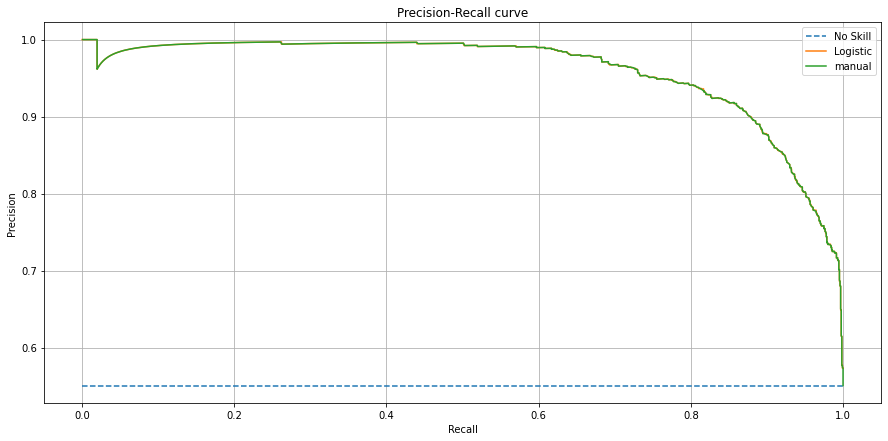

In [ ]:
plt.figure(figsize=(15, 7))

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(re, pr, label='Logistic')
plt.plot( recall_manual3, precision_manual3, label='manual')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend( loc = 'best' )
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score

In [ ]:
# площадь под кривой
average_precision_score( y_test, predictions3[:, 1] )

0.9601221906093587